In [21]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib
import os

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [16]:
def plot_conditional_r2(trait, indiv_group, cond_col, test_col):

    fig, axes = plt.subplots(
        figsize=(4, 1.7),
        dpi=150,
        ncols=2,
        sharey=True,
        gridspec_kw={"width_ratios": [1, 3]},
    )
    ## plot overall R2
    prefix = f"out/r2-diff/{trait}-{indiv_group}"
    df_overall_r2 = pd.read_csv(prefix + ".r2.tsv", sep="\t")
    df_overall_r2diff = pd.read_csv(prefix + ".r2diff.tsv", sep="\t")
    df_tmp = df_overall_r2[df_overall_r2.group == test_col]

    n_cat = len(df_tmp)
    cmap = plt.get_cmap("crest", n_cat)
    colors = [cmap(i) for i in range(n_cat)]
    x = np.arange(len(df_tmp))
    y = df_tmp.r2
    yerr = df_tmp.r2_se * 1.96
    axes[0].errorbar(
        x=x,
        y=y,
        yerr=yerr,
        fmt=" ",
        ecolor=colors,
    )
    axes[0].scatter(x, y, s=10, color=colors)
    axes[0].set_ylabel(f"{trait} $R^2$")
    axes[0].set_xlim(-1, len(df_tmp))
    axes[0].set_xticks([])
    axes[0].set_xlabel("Overall")
    ## plot conditional R2
    ax = axes[1]
    prefix = f"out/conditional-r2-diff/{trait}-{indiv_group}"
    r2_file_list = glob.glob(f"{prefix}.{cond_col}_*.r2.tsv")
    df_r2 = [pd.read_csv(f, sep="\t") for f in r2_file_list]

    for cond_i, df_tmp in enumerate(df_r2):
        df_tmp = df_tmp[df_tmp.group == test_col]

        if df_tmp.shape[0] == 3:
            df_tmp = df_tmp.iloc[[0, 2], :]
        index = np.arange(len(df_tmp))
        x = (index - np.median(index)) * 0.15 + cond_i
        y = df_tmp.r2
        yerr = df_tmp.r2_se * 1.96

        ax.errorbar(
            x=x,
            y=y,
            yerr=yerr,
            fmt=" ",
            ecolor=colors,
        )
        ax.scatter(x, y, s=10, color=colors)

    for i in range(len(df_r2) - 1):
        ax.axvline(x=i + 0.5, color="lightgray", lw=1.0)

    ax.set_xlim(-0.5, len(df_r2) - 0.5)
    ax.set_xticks(np.arange(len(df_r2)))
    ax.set_xticklabels(np.arange(1, len(df_r2) + 1))
    ax.set_xlabel(f"{covar_map[cond_col]} quintile")

    from matplotlib.lines import Line2D

    legend_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(colors))]
    fig.legend(
        legend_lines,
        np.arange(1, len(colors) + 1),
        title=f"{covar_map[test_col]} groups",
        ncol=len(colors),
        fontsize=6,
        loc="center",
        bbox_to_anchor=(0.55, 1.03),
        frameon=False,
    )

    fig.tight_layout()
    return fig, axes

In [17]:
TEST_COLS = [
    "SEX",
    "glasses",
    "AGE",
    "years_of_edu",
    "income",
    "DEPRIVATION_INDEX",
    "PC1",
    "PC2",
    "drink_alcohol",
    "ever_smoked",
    "log_BMI",
]

In [18]:
trait = "LDL"
indiv_group = "white"

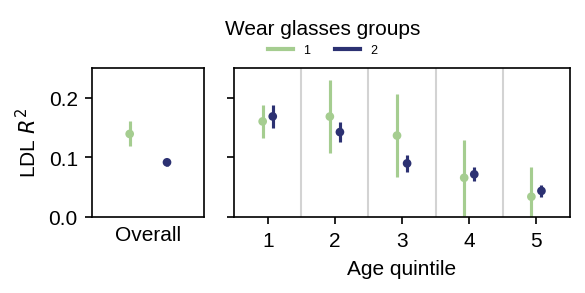

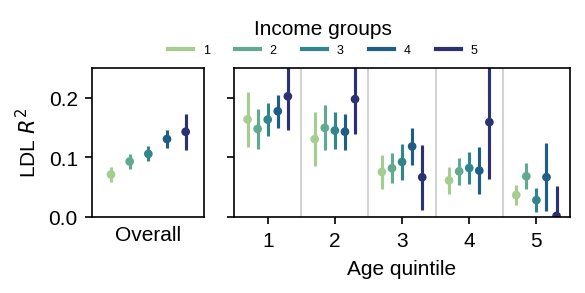

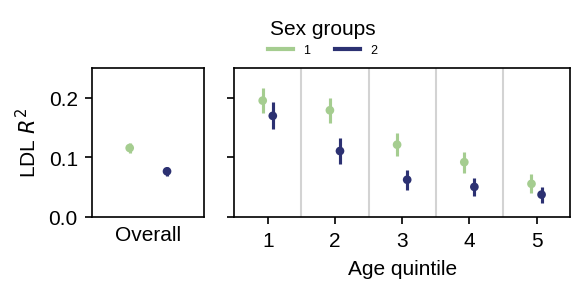

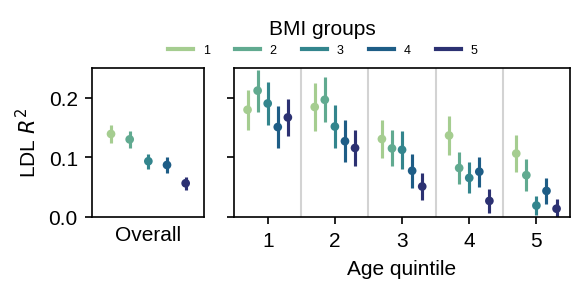

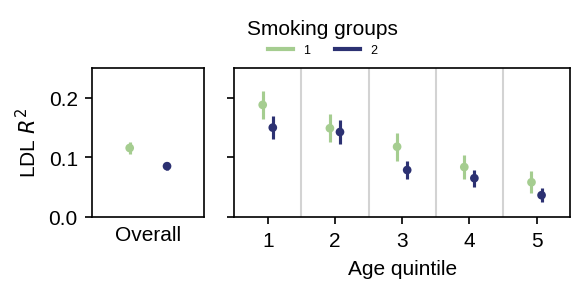

In [23]:
cond_col = "AGE"
out_dir = "results/conditional_r2/"
os.makedirs(out_dir, exist_ok=True)
for test_col in ["glasses", "income", "SEX", "log_BMI", "ever_smoked"]:
    fig, axes = plot_conditional_r2(
        trait=trait, indiv_group=indiv_group, cond_col=cond_col, test_col=test_col
    )
    axes[0].set_ylim(0, 0.25)
    plt.savefig(os.path.join(out_dir, f"{test_col}.pdf"), bbox_inches="tight")